In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pygam import LinearGAM, s


In [2]:
# Set up data folder and file paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file = os.path.join(data_folder, "spy_tickers_sample.csv")
json_file = os.path.join(data_folder, "income_statements.json")

# Define which fields to keep
desired_fields = [
    'symbol',
    'date',
    'revenue',
    'grossProfit',
    'operatingIncome',
    'netIncome',
    'eps',
    'ebitda',
    'costOfRevenue',
    'operatingExpenses'
]

# Try loading from cached JSON if it exists
if os.path.exists(json_file):
    print("Loading data from JSON cache...")
    with open(json_file, 'r') as f:
        records = json.load(f)
else:
    # Load tickers
    df = pd.read_csv(csv_file)
    tickers = df['Ticker'].dropna().tolist()

    API_KEY = 'YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6'
    records = []

    # Fetch most recent income statement per ticker
    for ticker in tickers:
        url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}'
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                row = data[0]
                row['symbol'] = ticker
                filtered_row = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered_row)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(1)  # Rate limiting

    # Save to JSON
    with open(json_file, 'w') as f:
        json.dump(records, f, indent=2)
    print("Saved data to JSON cache.")

# Convert to DataFrame
income_df = pd.DataFrame(records)

# Show sample
print(income_df.head())


Loading data from JSON cache...
         date symbol reportedCurrency         cik fillingDate  \
0  2024-09-28   AAPL              USD  0000320193  2024-11-01   
1  2024-06-30   MSFT              USD  0000789019  2024-07-30   
2  2024-12-31   AMZN              USD  0001018724  2025-02-07   
3  2025-01-26   NVDA              USD  0001045810  2025-02-26   
4  2024-12-31  GOOGL              USD  0001652044  2025-02-05   

          acceptedDate calendarYear period       revenue  costOfRevenue  ...  \
0  2024-11-01 06:01:36         2024     FY  391035000000   210352000000  ...   
1  2024-07-30 16:06:22         2024     FY  245122000000    74114000000  ...   
2  2025-02-06 18:40:29         2024     FY  637959000000   326288000000  ...   
3  2025-02-26 16:48:33         2025     FY  130497000000    32639000000  ...   
4  2025-02-04 20:41:40         2024     FY  350018000000   146306000000  ...   

   incomeBeforeTaxRatio  incomeTaxExpense     netIncome  netIncomeRatio  \
0              0.3157

In [9]:
# Paths
data_folder  = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file     = os.path.join(data_folder, "spy_tickers_sample.csv")
output_file  = os.path.join(data_folder, "income_growth.json")

# API setup
API_KEY  = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
BASE_URL = "https://financialmodelingprep.com/stable/income-statement-growth"

# Try loading from cache
if os.path.exists(output_file):
    print("Loading growth data from JSON cache...")
    with open(output_file, "r") as f:
        growth_records = json.load(f)

else:
    print("No cache found — fetching growth data from API...")
    # Load tickers
    df       = pd.read_csv(csv_file)
    tickers  = df['Ticker'].tolist()
    growth_records = []

    # Fetch and flatten all periods (Solution B)
    for ticker in tickers:
        url = f"{BASE_URL}?symbol={ticker}&apikey={API_KEY}"
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            data = resp.json()

            if isinstance(data, list) and data:
                for period in data:
                    period['symbol'] = ticker
                    growth_records.append(period)
            else:
                print(f"  • no growth data for {ticker}")

        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")

        time.sleep(1)  # respect rate limits

    # Save to JSON cache
    os.makedirs(data_folder, exist_ok=True)
    with open(output_file, "w") as f:
        json.dump(growth_records, f, indent=2)
    print(f"Saved {len(growth_records)} records to JSON cache.")

# Convert to DataFrame and inspect
df_growth = pd.DataFrame(growth_records)
print("Columns in growth DataFrame:", df_growth.columns.tolist())
df_growth.shape

Loading growth data from JSON cache...
Columns in growth DataFrame: ['symbol', 'date', 'fiscalYear', 'period', 'reportedCurrency', 'growthRevenue', 'growthCostOfRevenue', 'growthGrossProfit', 'growthGrossProfitRatio', 'growthResearchAndDevelopmentExpenses', 'growthGeneralAndAdministrativeExpenses', 'growthSellingAndMarketingExpenses', 'growthOtherExpenses', 'growthOperatingExpenses', 'growthCostAndExpenses', 'growthInterestIncome', 'growthInterestExpense', 'growthDepreciationAndAmortization', 'growthEBITDA', 'growthOperatingIncome', 'growthIncomeBeforeTax', 'growthIncomeTaxExpense', 'growthNetIncome', 'growthEPS', 'growthEPSDiluted', 'growthWeightedAverageShsOut', 'growthWeightedAverageShsOutDil', 'growthEBIT', 'growthNonOperatingIncomeExcludingInterest', 'growthNetInterestIncome', 'growthTotalOtherIncomeExpensesNet', 'growthNetIncomeFromContinuingOperations', 'growthOtherAdjustmentsToNetIncome', 'growthNetIncomeDeductions']


(100, 34)

In [12]:
# Define paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
tickers_csv_path = os.path.join(data_folder, "spy_tickers_sample.csv")
output_json_path = os.path.join(data_folder, "ratios.json")

# Try loading from cache
if os.path.exists(output_json_path):
    print("Loading ratios from JSON cache...")
    with open(output_json_path, "r") as f:
        all_ratios = json.load(f)
else:
    print("No cache found — fetching ratios from API...")
    tickers_df = pd.read_csv(tickers_csv_path)
    tickers = tickers_df['Ticker'].dropna().unique().tolist()

    api_key = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
    base_url = "https://financialmodelingprep.com/api/v3/ratios/{}?limit=1&apikey={}"

    all_ratios = []

    for ticker in tickers:
        try:
            url = base_url.format(ticker, api_key)
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                all_ratios.append(data[0])
            time.sleep(1)
        except Exception as e:
            print(f"Error fetching {ticker}: {e}")

    # Save to cache
    with open(output_json_path, "w") as f:
        json.dump(all_ratios, f, indent=2)
    print(f"Saved {len(all_ratios)} records to JSON cache.")

# Convert to DataFrame
df_ratios = pd.DataFrame(all_ratios)
df_ratios.columns

Loading ratios from JSON cache...


Index(['symbol', 'date', 'calendarYear', 'period', 'currentRatio',
       'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'daysOfInventoryOutstanding', 'operatingCycle',
       'daysOfPayablesOutstanding', 'cashConversionCycle', 'grossProfitMargin',
       'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin',
       'effectiveTaxRate', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit',
       'ebitPerRevenue', 'debtRatio', 'debtEquityRatio',
       'longTermDebtToCapitalization', 'totalDebtToCapitalization',
       'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier',
       'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover',
       'fixedAssetTurnover', 'assetTurnover', 'operatingCashFlowPerShare',
       'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio',
       'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio',
       'cashFlowCoverageRatios', 'shortTermCovera

In [13]:
# 1. Set up paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file    = os.path.join(data_folder, "spy_tickers_sample.csv")
json_file   = os.path.join(data_folder, "company_info.json")

# 2. Define the fields you want to keep
desired_fields = [
    "symbol", "companyName", "marketCap", "sector", "industry", "beta",
    "price", "lastAnnualDividend", "volume", "exchange", "exchangeShortName",
    "country", "isEtf", "isFund"
]

# 3. Load or fetch company info
records = []

if os.path.exists(json_file):
    print("Loading company info from JSON cache...")
    with open(json_file, "r") as f:
        records = json.load(f)

else:
    print("No cache found — fetching company info from API...")
    df      = pd.read_csv(csv_file)
    tickers = df['Ticker'].dropna().unique().tolist()
    print(f"Found {len(tickers)} unique tickers.")

    API_KEY  = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
    BASE_URL = "https://financialmodelingprep.com/api/v3/profile/{}?apikey={}"

    failed = []

    for i, ticker in enumerate(tickers, 1):
        url = BASE_URL.format(ticker, API_KEY)
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            data = resp.json()
            if isinstance(data, list) and data:
                row = data[0]
                filtered = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered)
            else:
                print(f"  • No profile data for {ticker}")
                failed.append(ticker)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
            failed.append(ticker)
        time.sleep(1)

    os.makedirs(data_folder, exist_ok=True)
    with open(json_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} company records to cache.")
    if failed:
        print(f"{len(failed)} tickers failed to fetch: {failed[:5]}...")

# 4. Convert to DataFrame and inspect
company_df = pd.DataFrame(records)
company_df.drop_duplicates(subset="symbol", inplace=True)

print("Columns returned:", company_df.columns.tolist())
print(company_df.columns)


Loading company info from JSON cache...
Columns returned: ['symbol', 'companyName', 'marketCap', 'sector', 'industry', 'beta', 'price', 'lastAnnualDividend', 'volume', 'exchange', 'exchangeShortName', 'country', 'isEtf', 'isFund']
Index(['symbol', 'companyName', 'marketCap', 'sector', 'industry', 'beta',
       'price', 'lastAnnualDividend', 'volume', 'exchange',
       'exchangeShortName', 'country', 'isEtf', 'isFund'],
      dtype='object')


In [7]:
# 1. Convert columns to numeric
df_ratios['priceEarningsRatio'] = pd.to_numeric(df_ratios['priceEarningsRatio'], errors='coerce')
df_growth['growthEPSDiluted']   = pd.to_numeric(df_growth['growthEPSDiluted'], errors='coerce')

# 2. Merge on ticker
merged_df = pd.merge(
    df_ratios[['symbol', 'priceEarningsRatio']],
    df_growth[['symbol', 'growthEPSDiluted']],
    on='symbol',
    how='inner'
)

# 3. Drop rows with missing values
reg_df = merged_df.dropna(subset=['priceEarningsRatio', 'growthEPSDiluted']).copy()

# 4. Filter out non-positive EPS growth
reg_df = reg_df[reg_df['growthEPSDiluted'] > 0]

# 5. Filter out non-positive P/E ratios (to avoid log issues)
reg_df = reg_df[reg_df['priceEarningsRatio'] > 0]


# 6. Cap EPS growth at 500% (5.0 in your units)
reg_df = reg_df[reg_df['growthEPSDiluted'] <= .3]


# 8. Log-transform the P/E ratio
reg_df['ln_PE'] = np.log(reg_df['priceEarningsRatio'])

# 9. Setup regression
X = sm.add_constant(reg_df['growthEPSDiluted'])
y = reg_df['ln_PE']

model = sm.OLS(y, X).fit()

# 8. Print results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  ln_PE   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     6.447
Date:                Mon, 11 Aug 2025   Prob (F-statistic):             0.0157
Time:                        10:38:48   Log-Likelihood:                -20.724
No. Observations:                  37   AIC:                             45.45
Df Residuals:                      35   BIC:                             48.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.9036      0.147  

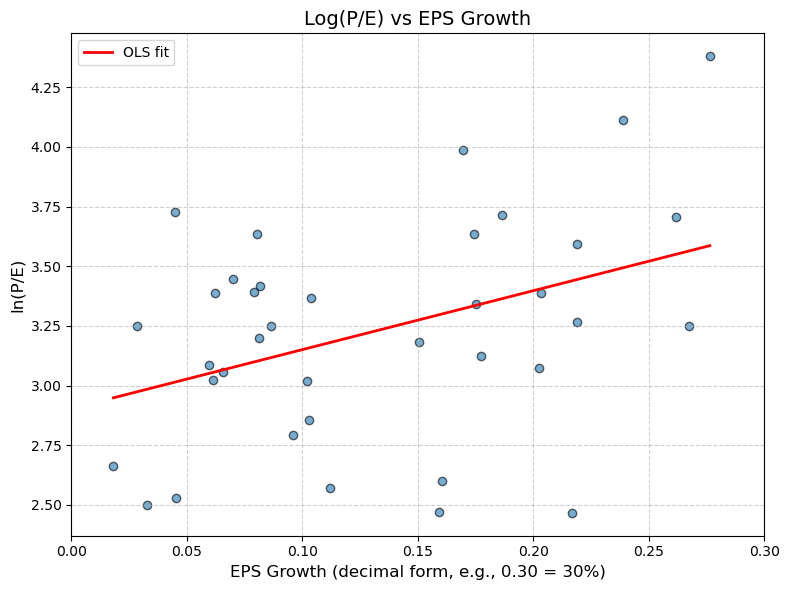

In [14]:
# Scatterplot
plt.figure(figsize=(8,6))
plt.scatter(reg_df['growthEPSDiluted'], reg_df['ln_PE'], alpha=0.6, edgecolors='k')

# Regression line
x_vals = np.linspace(reg_df['growthEPSDiluted'].min(), reg_df['growthEPSDiluted'].max(), 100)
plt.xlim(0, .3)
y_vals = model.params['const'] + model.params['growthEPSDiluted'] * x_vals
plt.plot(x_vals, y_vals, color='red', linewidth=2, label='OLS fit')

# Labels & title
plt.xlabel("EPS Growth (decimal form, e.g., 0.30 = 30%)", fontsize=12)
plt.ylabel("ln(P/E)", fontsize=12)
plt.title("Log(P/E) vs EPS Growth", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
#CONFIRM THE HYPERPARAMTER OF THE LOG REGRESION 

from sklearn.metrics import mean_squared_error

best_cap = None
best_mse = float('inf')
results = []

for cap in np.arange(0.05, ., 0.02):  # test from 0.05 to 1.0 in steps of 0.05
    # Filter data for current cap
    temp_df = reg_df[reg_df['growthEPSDiluted'] <= cap].copy()

    if temp_df.shape[0] < 5:  # skip if too few observations
        continue

    # Run regression
    X = sm.add_constant(temp_df['growthEPSDiluted'])
    y = np.log(temp_df['priceEarningsRatio'])
    model = sm.OLS(y, X).fit()

    # Calculate MSE
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)

    results.append((cap, mse))

    # Track best cap
    if mse < best_mse:
        best_mse = mse
        best_cap = cap

# Display results
print("Best cap:", best_cap)
print("Lowest MSE:", best_mse)
print("\nAll results:")
for cap, mse in results:
    print(f"Cap: {cap:.2f}, MSE: {mse:.6f}")


Best cap: 0.09000000000000001
Lowest MSE: 0.08906046133730719

All results:
Cap: 0.05, MSE: 0.211940
Cap: 0.07, MSE: 0.119569
Cap: 0.09, MSE: 0.089060
Cap: 0.11, MSE: 0.108201
Cap: 0.13, MSE: 0.124304
Cap: 0.15, MSE: 0.124304
Cap: 0.17, MSE: 0.164356
Cap: 0.19, MSE: 0.155833
Cap: 0.21, MSE: 0.147691
Cap: 0.23, MSE: 0.157569
Cap: 0.25, MSE: 0.170712
Cap: 0.27, MSE: 0.164316
Cap: 0.29, MSE: 0.179484


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.0959
Link Function:                     IdentityLink Log Likelihood:                                   -55.6568
Number of Samples:                           37 AIC:                                              129.5054
                                                AICc:                                              136.332
                                                GCV:                                                0.2641
                                                Scale:                                              0.1626
                                                Pseudo R-Squared:                                   0.4022
Feature Function                  Lam

/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_26677/947684930.py:16: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


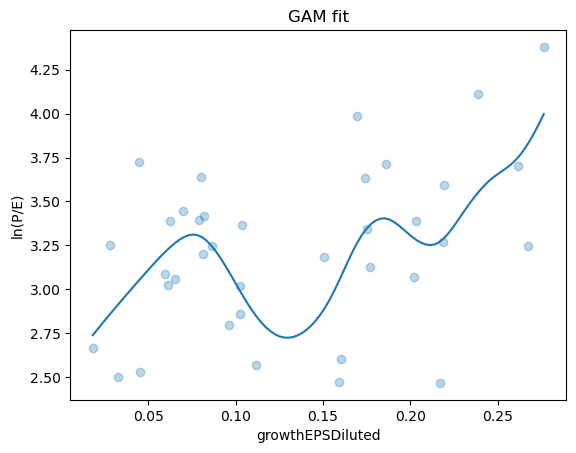

In [17]:
# Install if you haven't:
# pip install pygam

# Example: regress ln_PE on growthEPSDiluted with a smooth term
X = reg_df['growthEPSDiluted'].values.reshape(-1,1)
y = np.log(reg_df['priceEarningsRatio'])

# Fit GAM with a spline term for growth
gam = LinearGAM(s(0)).fit(X, y)

# Summary
print(gam.summary())

# Plot partial dependence (effect of growth on ln_PE)
XX = np.linspace(X.min(), X.max(), 100)
plt.plot(XX, gam.predict(XX))
plt.scatter(X, y, alpha=0.3)
plt.xlabel('growthEPSDiluted')
plt.ylabel('ln(P/E)')
plt.title('GAM fit')
plt.show()
